In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pywt

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks, stft

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

%matplotlib inline  

data_dir = './data/npy/augment'
fs = 100.0
data = []
for f in os.listdir(data_dir):
    data.append(np.load(os.path.join(data_dir, f)))
    
walk1 = np.load('./data/npy/walk1.npy')
walk2 = np.load('./data/npy/walk2.npy')
walk3 = np.load('./data/npy/walk_regr.npy')
walk_all = np.vstack((walk1,walk2))

train = walk_all[:270000,:]
test = walk_all[270000:,:]

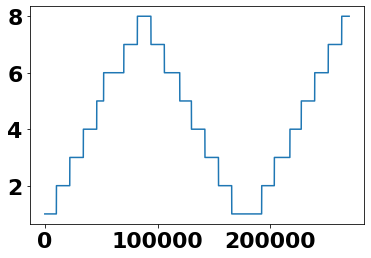

In [32]:
plt.plot(train[:,-1])

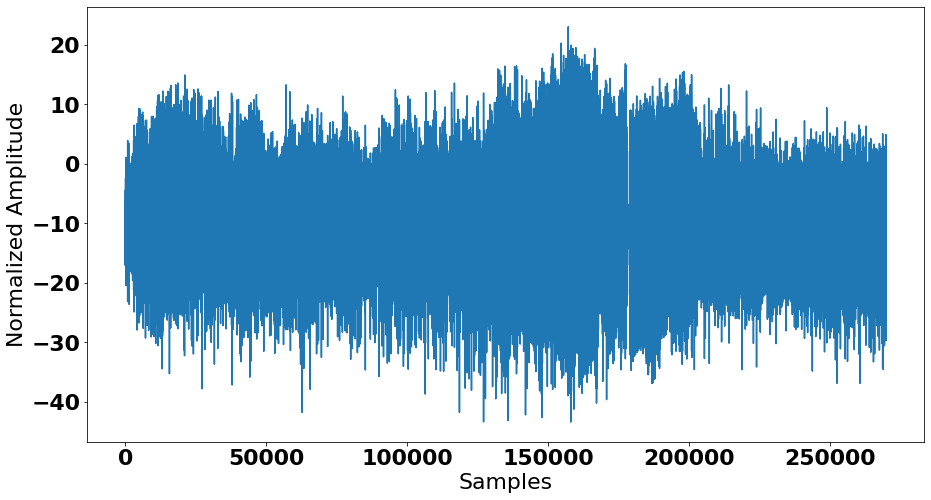

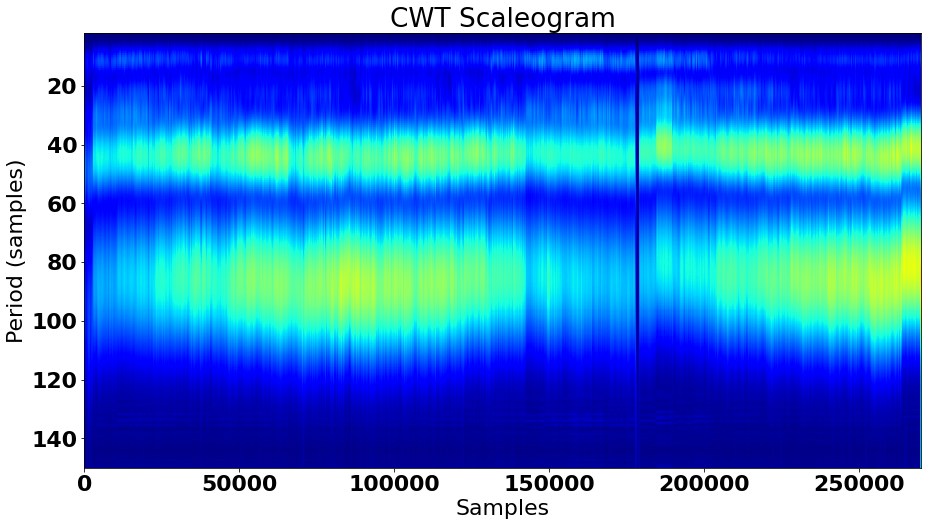

c:\python37\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  del sys.path[0]


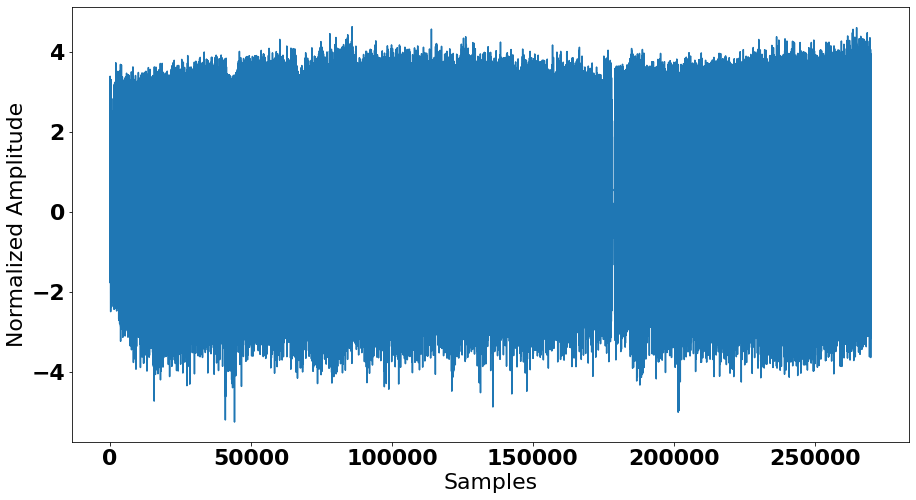

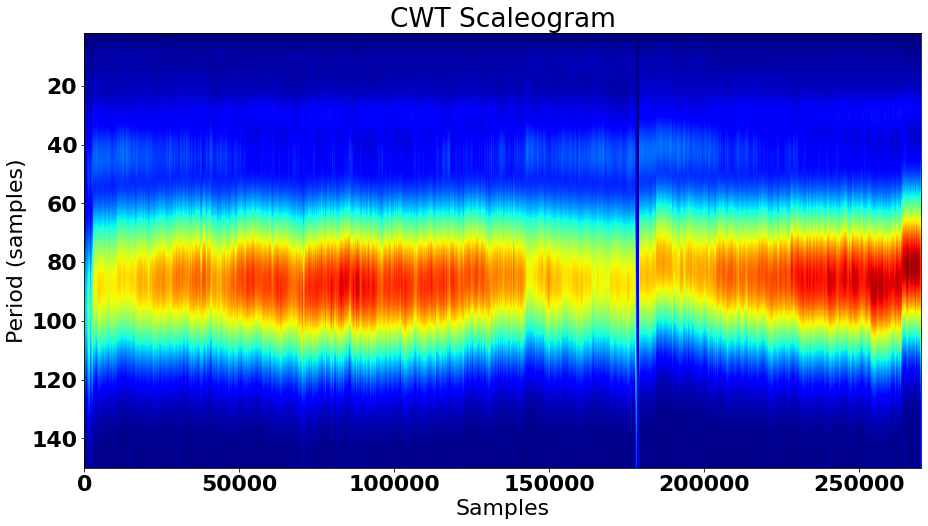

c:\python37\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  del sys.path[0]


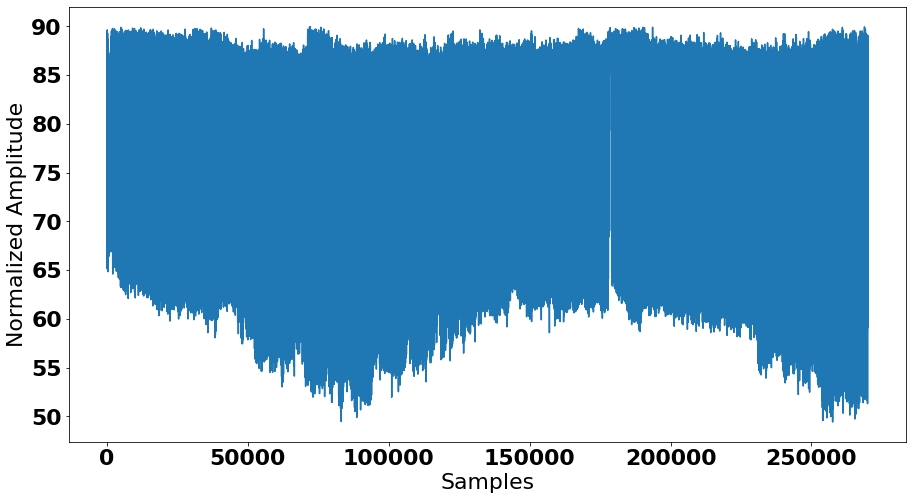

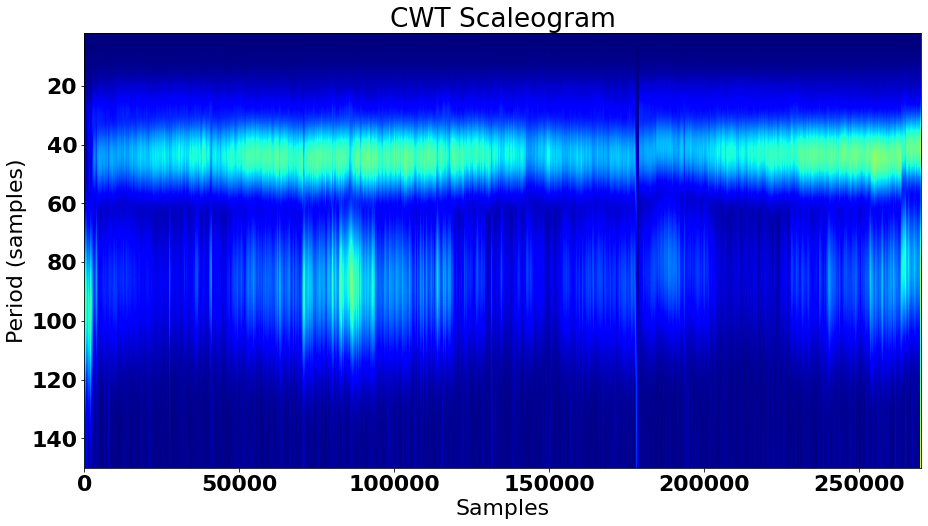

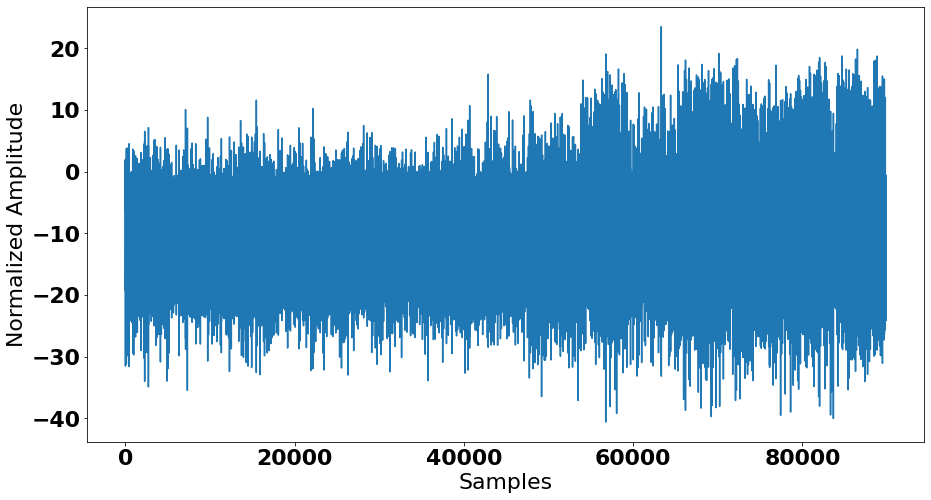

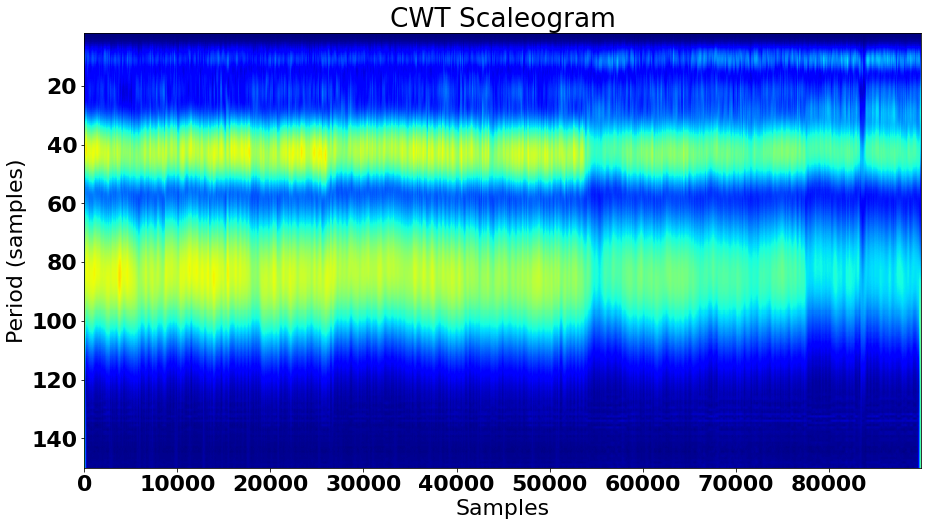

c:\python37\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  del sys.path[0]


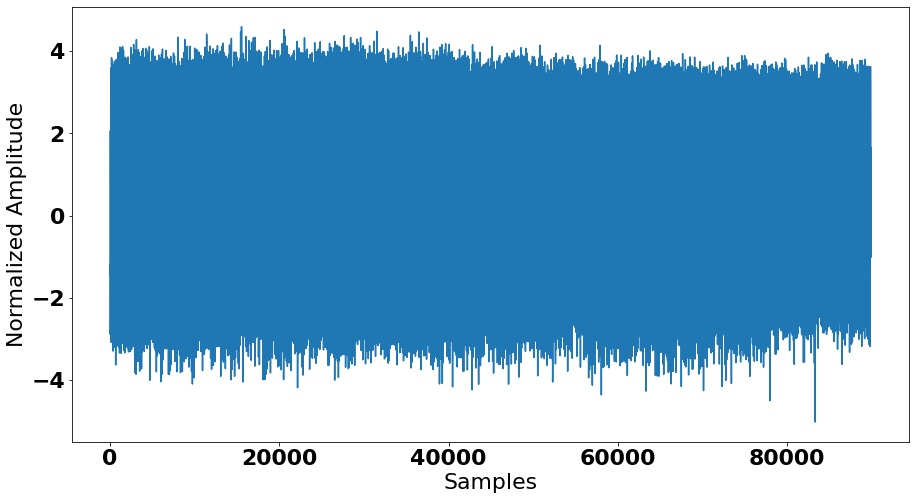

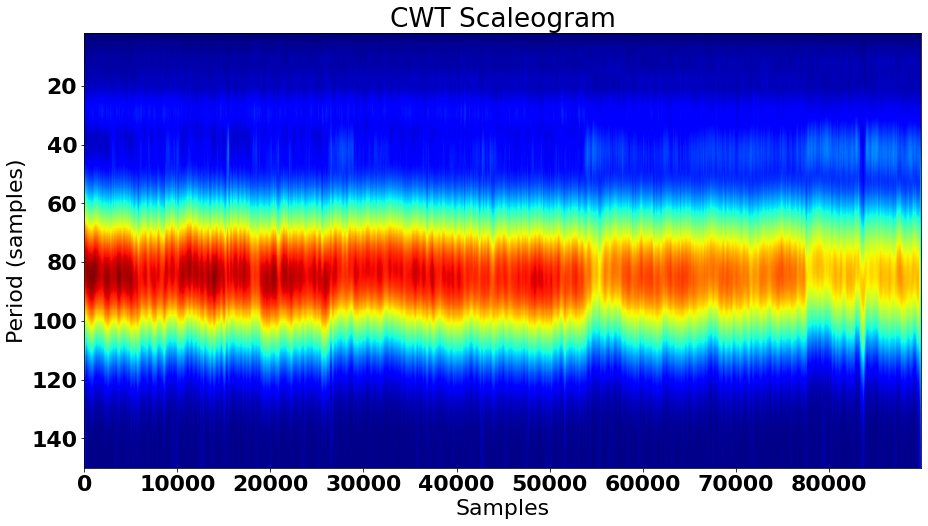

c:\python37\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  del sys.path[0]


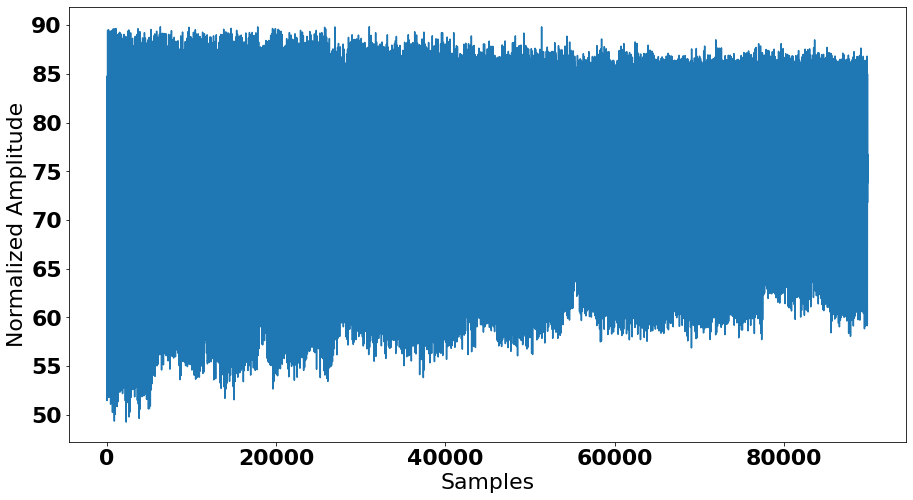

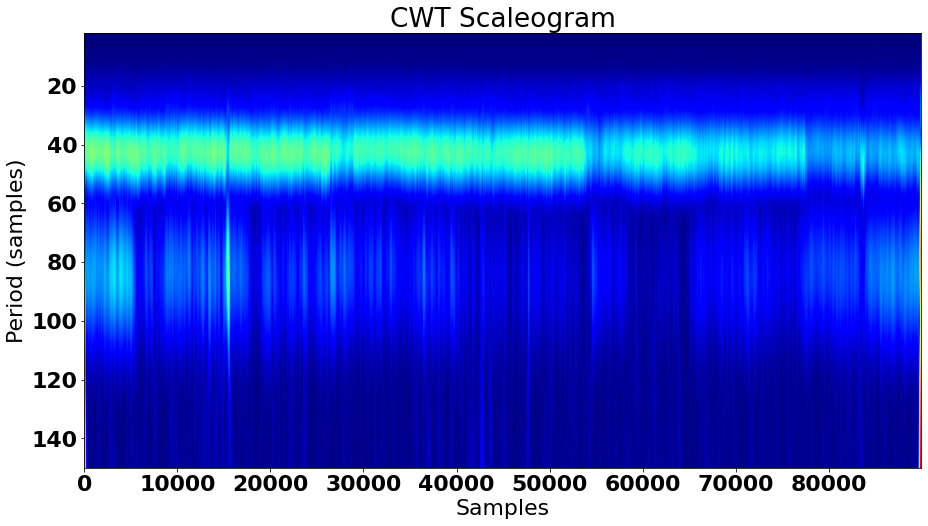

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
c:\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   47.3s finished


In [31]:

conv_width = 1
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def get_scalogram_coefs(x, features, fs):
    all_coefs = []
    for feat in features:
        scales = np.arange(2, fs*2)
        coefs, freqs = pywt.cwt(x[:,feat], scales, 'cmor-1-1')

        coefs = np.abs(coefs)

        if all_coefs == []:
            all_coefs = coefs[0:100,:]

        else:
            all_coefs = np.vstack((all_coefs,coefs[0:100,:]))


        plt.figure(figsize=(15,8))
        plt.plot(x[:,feat])
        plt.xlabel('Samples')
        plt.ylabel('Normalized Amplitude')

        plt.figure(figsize=(15,8))
        plt.imshow(coefs, extent=[0, x.shape[0], 150, 2], cmap='jet', aspect='auto',
                    vmax=coefs.max(), vmin=-coefs.min())
        plt.title('CWT Scaleogram')
        plt.xlabel('Samples')
        plt.ylabel('Period (samples)')
        plt.show()
        
    return all_coefs

X_train = train[:,:9]
Y_train = train[:,9].astype(int)
X_test = test[:,:9]
Y_test = test[:,9].astype(int)

all_coefs_train = get_scalogram_coefs(X_train, [1,3,7], 100)
all_coefs_test = get_scalogram_coefs(X_test, [1,3,7], 100)
coefs_train_scaled = preprocessing.scale(all_coefs_train.T)
#coefs_train_reduced = PCA(n_components=2).fit_transform(coefs_train_scaled)
coefs_test_scaled = preprocessing.scale(all_coefs_test.T)
#coefs_test_reduced = PCA(n_components=2).fit_transform(coefs_test_scaled)
#coefs_embedded = TSNE(n_components=2, perplexity=50, verbose=True).fit_transform(coefs_reduced)

scaler = preprocessing.StandardScaler()
scaler.fit(coefs_train_scaled)
x_train = scaler.transform(coefs_train_scaled)
x_test = scaler.transform(coefs_test_scaled)
clf = LogisticRegression(random_state=0, verbose=1, max_iter=100).fit(x_train, Y_train)




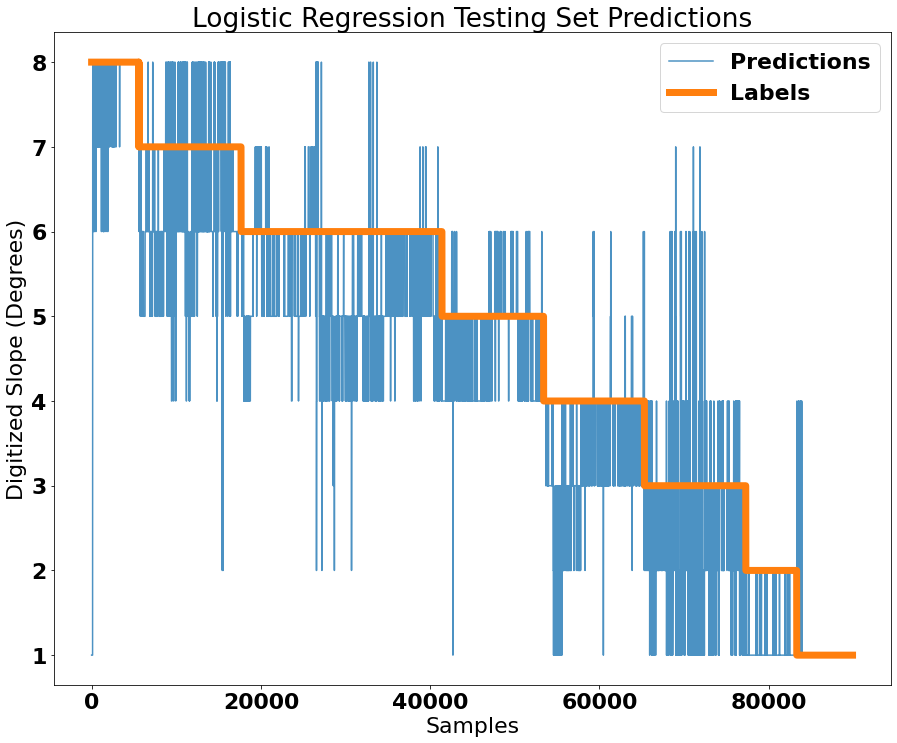

Test RMSE: 1.0102693911763436


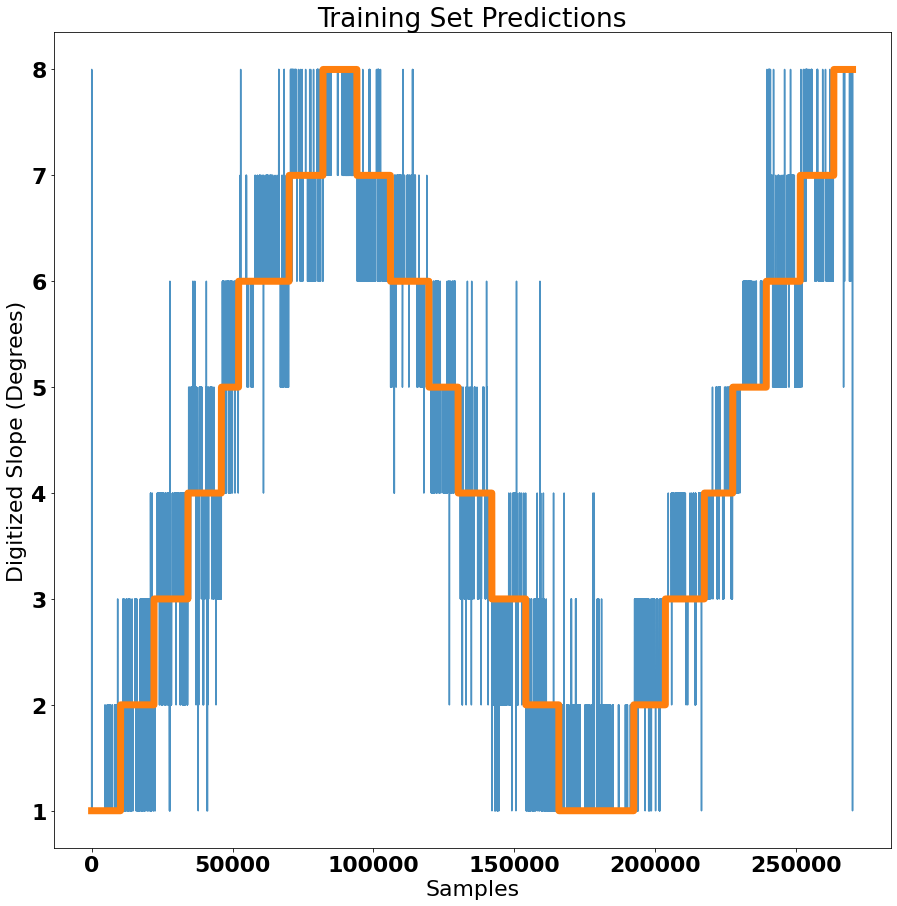

Train RMSE: 0.4641599341223286


In [28]:
import matplotlib
font1 = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font1)

test_pred = moving_average(clf.predict(x_test),conv_width)
plt.figure(figsize=(15,12))
plt.plot(test_pred, alpha=0.8, label='Predictions')
plt.plot(Y_test[conv_width-1:], linewidth=7, label='Labels')
plt.title('Logistic Regression Predictions')
plt.xlabel('Samples')
plt.ylabel('Digitized Slope (Degrees)')
plt.legend()
plt.show()

print('Test RMSE: {}'.format(np.sqrt(np.mean((test_pred-Y_test[conv_width-1:])**2))))

train_pred = moving_average(clf.predict(x_train),conv_width)
plt.figure(figsize=(15,15))
plt.plot(train_pred, alpha=0.8, label='Predictions')
plt.plot(Y_train[conv_width-1:],linewidth=7, label='Labels')
plt.title('Training Set Predictions')
plt.xlabel('Samples')
plt.ylabel('Digitized Slope (Degrees)')

plt.show()

print('Train RMSE: {}'.format(np.sqrt(np.mean((train_pred-Y_train[conv_width-1:])**2))))



## to_plot = [50000,55000]
plt.figure()
plt.plot(clf.predict(x[to_plot[0]: to_plot[1]]))
plt.plot(Y[to_plot[0]: to_plot[1]])
plt.show()

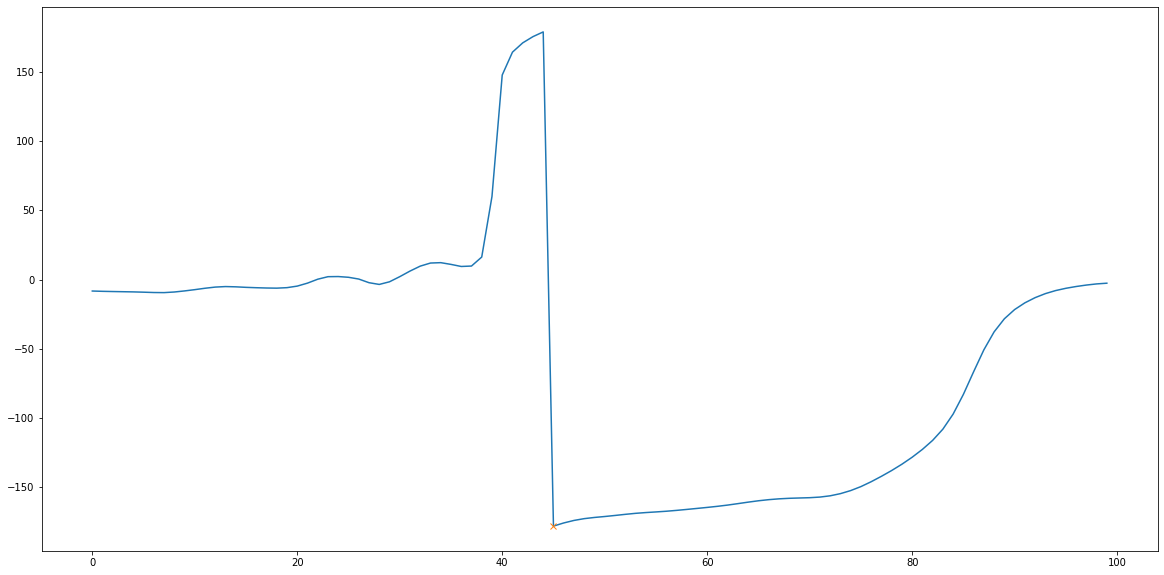

In [169]:
roll = walk1[:100,8]
peaks, _ = find_peaks(-roll, height=100, width=20)

plt.figure(figsize=(20,10))
plt.plot(roll)
plt.plot(peaks, roll[peaks], 'x')

Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

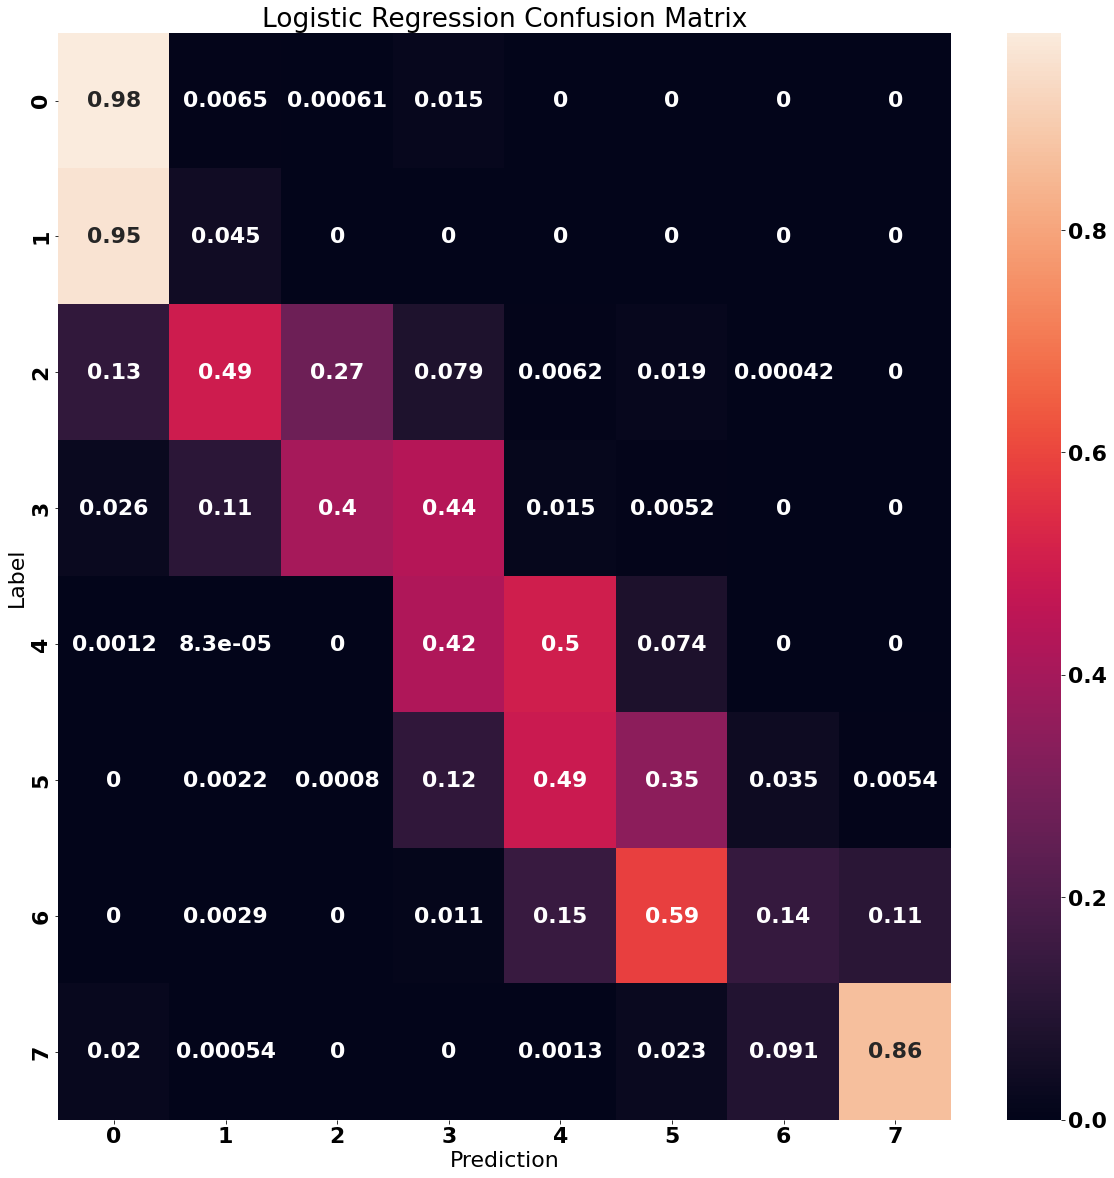

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(figsize=(20,20))
sns.heatmap(confusion_matrix(Y_test[conv_width-1:], test_pred, normalize='true'), annot=True)
plt.ylabel('Label')
plt.xlabel('Prediction')
plt.title('Logistic Regression Confusion Matrix')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  9.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.0s finished


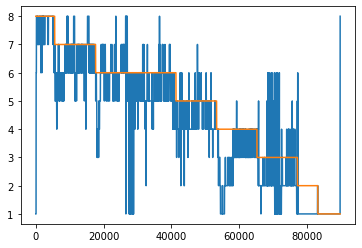

0.41446431749421603


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    6.1s finished


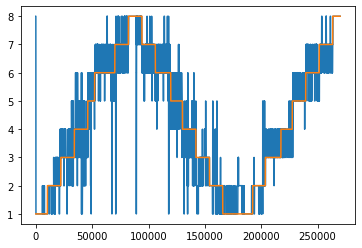

0.8483703703703703


In [63]:
clf_forest = RandomForestClassifier(n_estimators=300, max_depth=5, random_state=0, verbose=True)
clf_forest.fit(x_train, Y_train)

plt.figure()
plt.plot(clf_forest.predict(x_test))
plt.plot(Y_test)
plt.show()

print(clf.score(x_test, Y_test))

plt.figure()
plt.plot(clf_forest.predict(x_train))
plt.plot(Y_train)
plt.show()

print(clf.score(x_train, Y_train))

In [3]:
np.arange(2, fs*2)

array([  2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
        24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,
        35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,
        57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,
        68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,
        79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,
        90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100.,
       101., 102., 103., 104., 105., 106., 107., 108., 109., 110., 111.,
       112., 113., 114., 115., 116., 117., 118., 119., 120., 121., 122.,
       123., 124., 125., 126., 127., 128., 129., 130., 131., 132., 133.,
       134., 135., 136., 137., 138., 139., 140., 141., 142., 143., 144.,
       145., 146., 147., 148., 149., 150., 151., 15